In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_df = pd.read_csv(
    'train-wrangled2.csv',
    index_col=0,
    dtype={
        'fullVisitorId': 'str',
        'trafficSource.campaignCode': 'str',
        'visitId': 'str'
    },
    parse_dates=['date'])
train_df.shape

(903653, 35)

In [5]:
a = train_df['device.browser'].unique()

In [4]:
from difflib import get_close_matches

In [12]:
for browser in [
        'chrome', 'safari', 'firefox', 'internet explorer', 'edge', 'opera',
        'coc coc', 'maxthon', 'iron'
]:
    print(browser, get_close_matches(browser, a, 4, 0.6))

chrome ['Nichrome', 'Chrome']
safari ['Safari']
firefox ['Firefox']
internet explorer ['Internet Explorer']
edge ['Edge']
opera ['Opera']
coc coc ['Coc Coc']
maxthon ['Maxthon']
iron ['Iron']


In [84]:
test_df = pd.read_csv(
    'test-wrangled2.csv',
    index_col=0,
    dtype={
        'fullVisitorId': 'str',
        'trafficSource.campaignCode': 'str',
        'visitId': 'str'
    },
    parse_dates=['date'])
test_df.shape

(804684, 34)

### Extracting features from visitStartTime

In [85]:
import countries
from pytz import all_timezones

In [86]:
timezones_dict = {'timezone': [], 'name': []}

for d in countries.countries:
    timezones_dict['timezone'].append(d['timezones'])
    timezones_dict['name'].append(d['name'])

timezones_df = pd.DataFrame(timezones_dict)

timezones_df.replace(
    to_replace=[
        'Czech Republic', 'Bosnia and Herzegovina', 'Ivory Coast', 'Macedonia',
        'Myanmar', 'Trinidad and Tobago', 'Turks and Caicos Islands',
        'Reunion', 'Saint Kitts and Nevis', 'Democratic Republic of the Congo',
        'Macao', 'Saint Lucia', 'Curacao', 'Antigua and Barbuda',
        'Saint Vincent and the Grenadines', 'Aland Islands',
        'Saint Pierre and Miquelon', 'East Timor',
        'Bonaire, Saint Eustatius and Saba ', 'Republic of the Congo',
        'Saint Martin', 'Sao Tome and Principe', 'Saint Barthelemy'
    ],
    value=[
        'Czechia', 'Bosnia & Herzegovina', 'Côte d’Ivoire',
        'Macedonia (FYROM)', 'Myanmar (Burma)', 'Trinidad & Tobago',
        'Turks & Caicos Islands', 'Réunion', 'St. Kitts & Nevis',
        'Congo - Kinshasa', 'Macau', 'St. Lucia', 'Curaçao',
        'Antigua & Barbuda', 'St. Vincent & Grenadines', 'Åland Islands',
        'St. Pierre & Miquelon', 'Timor-Leste', 'Caribbean Netherlands',
        'Congo - Brazzaville', 'St. Martin', 'São Tomé & Príncipe',
        'St. Barthélemy'
    ],
    inplace=True)

In [87]:
def merge_timezones(df):
    df = df.merge(
        timezones_df,
        how='left',
        left_on='geoNetwork.country',
        right_on='name')

    return df

In [88]:
def clean_timezone(x):
    if type(x['timezone']) != list:
        return x['timezone']
    else:
        if len(x['timezone']) < 2:
            return x['timezone'][0]
        else:
            for timezone in x['timezone']:
                if (str(x['geoNetwork.city']).replace(' ', '_')
                        or str(x['geoNetwork.region']).replace(' ', '_')
                        or str(x['geoNetwork.metro']).replace(
                            ' ', '_')) in str(timezone):
                    return timezone
    return np.random.choice(x['timezone'])

In [89]:
def adjust_tz(df):
    try:
        return df['datetime'].tz_convert(df['timezone'])
    except:
        print(df)

In [90]:
def process_dates(df):
    df = merge_timezones(df)
    df['timezone'] = df[[
        'timezone', 'geoNetwork.city', 'geoNetwork.region', 'geoNetwork.metro'
    ]].apply(
        lambda x: clean_timezone(x), axis=1)
    
    df['datetime'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['datetime'] = df['datetime'].apply(lambda x: x.tz_localize('UTC'))
    df['local_dt'] = df.loc[df['timezone'].notnull(),
                            ['datetime', 'timezone']].apply(
                                lambda x: adjust_tz(x), axis=1)
    df['local_dt'] = df.loc[df['local_dt'].notnull(), 'local_dt'].apply(
        lambda x: x.tz_localize(None))
    #df['year'] = df['local_dt'].dt.year
    #df['month'] = df['local_dt'].dt.month
    df['day'] = df['local_dt'].dt.day
    df['hour'] = df['local_dt'].dt.hour
    #df['dayofyear'] = df['local_dt'].dt.dayofyear
    #df['dayofyear'] = df['local_dt'].dt.dayofyear
    #df['week'] = df['local_dt'].dt.week
    df['dayofweek'] = df['local_dt'].dt.dayofweek
    #df['weekday_name'] = df['local_dt'].dt.weekday_name
    #df['quarter'] = df['local_dt'].dt.quarter

    return df

In [ ]:
train_df = process_dates(train_df)
test_df = process_dates(test_df)

In [ ]:
train_df.to_csv('./train-times.csv')
test_df.to_csv('./test-times.csv')

## Feature engineering

In [ ]:
train_df[
    'hits/pageview'] = train_df['totals.hits'] / train_df['totals.pageviews']
test_df[
    'hits/pageview'] = test_df['totals.hits'] / test_df['totals.pageviews']

In [ ]:
first_date =  train_df['date'][0]
train_df['date'] = (train_df['date'] - first_date).dt.days
test_df['date'] = (test_df['date'] - first_date).dt.days

In [ ]:
categorical = train_df.drop(columns=[
    'fullVisitorId', 'sessionId', 'visitId', 'totals.transactionRevenue',
])
numerical = categorical.copy()
categorical = categorical.select_dtypes('object').columns
numerical = numerical.select_dtypes('number').columns

print('Categorical features: ' + str(len(categorical)))
print('Numerical features: ' + str(len(numerical)))

In [ ]:
train_df[categorical].dtypes

In [ ]:
train_df[numerical].dtypes

In [ ]:
other = list(set(train_df.columns) - set(categorical) - set(numerical))
train_df[other].dtypes

### Encodings / Imputations

In [ ]:
train_df.select_dtypes('object').isnull().sum()

In [ ]:
encoder = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in categorical:
    encoder.fit(train_df.append(test_df, sort=False)[col].astype('str'))
    # Transform both training and testing data
    train_df[col] = encoder.transform(train_df[col].astype('str'))
    test_df[col] = encoder.transform(test_df[col].astype('str'))
    
    # Keep track of how many columns were label encoded
    le_count += 1
            
print('%d columns were label encoded.' % le_count)

In [ ]:
train_df[numerical].isnull().sum()

In [ ]:
train_df.loc[:, categorical] = train_df[categorical].fillna('unknown')
test_df.loc[:, categorical] = test_df.loc[:, categorical].fillna('unknown')
train_df.loc[:,'totals.transactionRevenue'].fillna(0, inplace=True)

### Splitting Training / Validation

In [ ]:
def get_folds(df=None, n_splits=5):
    """Returns dataframe indices corresponding to Visitors Group KFold"""
    # Get sorted unique visitors
    unique_vis = np.array(sorted(df['fullVisitorId'].unique()))

    # Get folds
    folds = GroupKFold(n_splits=n_splits)
    fold_ids = []
    ids = np.arange(df.shape[0])
    for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
        fold_ids.append(
            [
                ids[df['fullVisitorId'].isin(unique_vis[trn_vis])],
                ids[df['fullVisitorId'].isin(unique_vis[val_vis])]
            ]
        )

    return fold_ids

In [ ]:
X.dtypes

In [ ]:
threshold = int(train_df.shape[0] * 0.8)
X = train_df.drop(columns=[
    'fullVisitorId', 'sessionId', 'visitId', 'totals.transactionRevenue',
    'datetime', 'local_dt'
])
y = np.log1p(train_df['totals.transactionRevenue'])
X_train = X.loc[:threshold]
y_train = y[:threshold + 1]
X_val = X.loc[threshold:]
y_val = y[threshold:]
X_test = test_df.drop(columns=['fullVisitorId', 'sessionId', 'visitId'])

In [ ]:
def train_model(X_train,
                   y_train,
                   eval_set = None,
                   n_estimators=1000,
                   early_stopping_rounds=100):

    reg = lgb.LGBMRegressor(
        boosting_type='gbdt',
        num_leaves=31,
        max_depth=-1,
        learning_rate=0.02,
        n_estimators=n_estimators,
        subsample_for_bin=200000,
        objective='regression',
        class_weight=None,
        min_split_gain=0.0,
        min_child_weight=0.001,
        min_child_samples=20,
        subsample=1.0,
        subsample_freq=0,
        colsample_bytree=1.0,
        reg_alpha=0.0,
        reg_lambda=0.0,
        random_state=42,
        n_jobs=-1,
        silent=False,
        importance_type='split')

    reg.fit(
        X=X_train,
        y=y_train,
        sample_weight=None,
        init_score=None,
        eval_set=eval_set,
        eval_names=None,
        eval_sample_weight=None,
        eval_init_score=None,
        eval_metric='rmse',
        early_stopping_rounds=early_stopping_rounds,
        verbose=1,
        feature_name='auto',
        categorical_feature='auto',
        callbacks=None)

    print('best iteration: ' + str(reg.best_iteration_))
    print('best score: ' + str(reg.best_score_))

    return reg

In [ ]:
model = train_model(X_train, y_train, [(X_val, y_val)])

In [ ]:
def prediction(model, X, y):
    pred = model.predict(X, num_iteration=model.best_iteration_)
    pred[pred < 0] = 0
    df = train_df.loc[X.index, ['fullVisitorId']]
    df['real'] = np.expm1(y)
    df['predicted'] = np.expm1(pred)
    df = df.groupby('fullVisitorId').sum()
    df['predicted'] = np.log1p(df["predicted"])
    df['real'] = np.log1p(df['real'])
        
    return df

In [ ]:
def scoring(model, X, y, operation):
    df = prediction(model, X, y)
    print(operation + ' error: ' +
          str(np.sqrt(mean_squared_error(df['predicted'], df['real']))))

In [ ]:
scoring(model, X_train, y_train, 'Training')
scoring(model, X_val, y_val, 'Validation')

In [66]:
scoring(model, X_train, y_train, 'Training')
scoring(model, X_val, y_val, 'Validation')

Training error: 1.4956818844510245
Validation error: 1.6406721125457178


1.4541 on LB

In [67]:
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_,
    }).sort_values(
    'Importance', ascending=False)
importance_df

Feature  Importance
42                                 hits/pageview        2914
18                              totals.pageviews        2459
16                                   totals.hits        1638
1                                           date        1592
2                                    visitNumber        1472
36                                          hour        1292
31                                      timezone        1253
37                                     dayofyear        1000
35                                           day         880
12                      geoNetwork.networkDomain         778
8                                geoNetwork.city         739
3                                 visitStartTime         682
7                         device.operatingSystem         552
13                             geoNetwork.region         548
39                                     dayofweek         475
11                              geoNetwork.metro         406
10                            geoNetwork.country         384
29                    trafficSource.referralPath         370
26                    trafficSource.isTrueDirect         339
40                                  weekday_name         308
0                                channelGrouping         249
30                          trafficSource.source         215
27                         trafficSource.keyword         200
5                          device.deviceCategory         187
9                           geoNetwork.continent         162
6                                device.isMobile         161
32                                          name         158
28                          trafficSource.medium         121
4                                 device.browser         119
34                                         month          99
21          trafficSource.adwordsClickInfo.gclId          70
38                                          week          44
14                       geoNetwork.subContinent          21
19                       trafficSource.adContent           5
20  trafficSource.adwordsClickInfo.adNetworkType           5
17                              totals.newVisits           2
25                        trafficSource.campaign           1
15                                totals.bounces           0
22      trafficSource.adwordsClickInfo.isVideoAd           0
33                                          year           0
24           trafficSource.adwordsClickInfo.slot           0
23           trafficSource.adwordsClickInfo.page           0
41                                       quarter           0

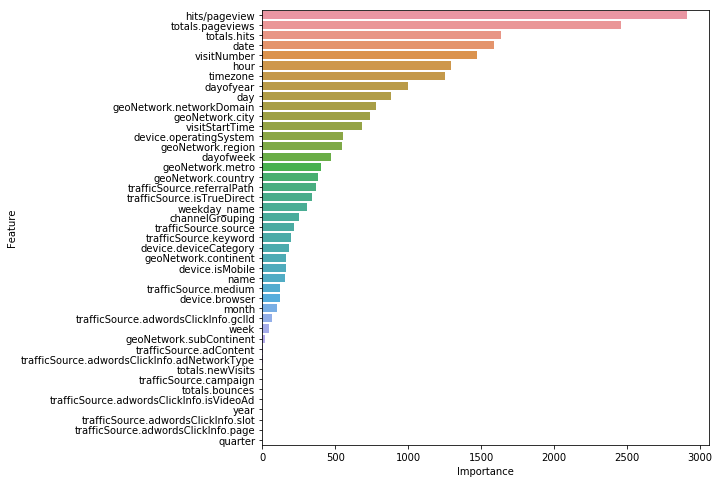

In [79]:
plt.figure(figsize=(8, 8))
sns.barplot(data=importance_df, x='Importance', y='Feature')

## Train on the full dataset

In [76]:
final_model = train_model(
    X[columns],
    y,
    early_stopping_rounds=None,
    n_estimators=model.best_iteration_)

best iteration: None
best score: defaultdict(<class 'dict'>, {})


In [77]:
result = final_model.predict(X_test[columns])
result[result < 0] = 0
result_df = test_df[['fullVisitorId']]
result_df['PredictedLogRevenue'] = np.expm1(result)
result_df = result_df.groupby('fullVisitorId', as_index=False).sum()
result_df['PredictedLogRevenue'] = np.log1p(result_df['PredictedLogRevenue'])

/home/yannis/miniconda3/envs/ga/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [78]:
result_df.to_csv('submission(lgbm-label encoding+FE+time).csv', index=False)

1.4421 on LB

In [81]:
train_df['totals.hits'].describe()

count    903653.000000
mean          4.596538
std           9.641437
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         500.000000
Name: totals.hits, dtype: float64